In [6]:
# Load Libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

from pybaseball import statcast
from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
from pybaseball import pitching_stats
from pybaseball import batting_stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from pybaseball import pitching_stats_bref
from pybaseball import statcast_batter

In [7]:
pyb.cache.enable()

In [45]:
data = statcast(start_dt="2023-03-30", end_dt="2023-10-24")
columns = ['game_date', 'player_name', 'batter', 'p_throws', 'stand', 'pitch_type', 'release_speed', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'effective_speed', 'release_spin_rate', 'release_extension', 'plate_x', 'plate_z', 'description']


This is a large query, it may take a moment to complete


100%|██████████| 209/209 [00:30<00:00,  6.81it/s]


In [46]:
df = data[columns]

# **Data Cleaning**

In [47]:
# Rename columns for easier access
column_mapping = {
    'game_date': 'date',
    'player_name': 'pitcher_name',
    'batter': 'batter_id',
    'p_throws': 'p_hand',
    'stand': 'batter_side',
    'pitch_type': 'pitch_type',
    'release_speed': 'velocity',
    'pfx_x': 'horizontal_break',
    'pfx_z': 'induced_vertical_break',
    'release_pos_x': 'release_side',
    'release_pos_y': 'release_dist_from_C',
    'release_pos_z': 'release_height',
    'spin_axis': 'spin_axis',
    'effective_speed': 'effective_velocity',
    'release_spin_rate': 'spin_rate',
    'release_extension': 'extension',
    'plate_x': 'pitch_height',
    'plate_z': 'pitch_side'
}

df.rename(columns=column_mapping, inplace=True)

c:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [48]:
# release side, release height, induced vertical break, extension, velocity, horizontal break, differential break, spin rate, spin axis
# pitcher name, pitcher team, pitch type

# Edit the pitcher names so the first name is first and the last name is last
df['pitcher_name'] = df['pitcher_name'].str.split(' ', expand=True)[1] + ' ' + df['pitcher_name'].str.split(' ', expand=True)[0]

# Remove the comma from the last name
df['pitcher_name'] = df['pitcher_name'].replace(',', '', regex=True)

<ipython-input-48-630fba45d089>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pitcher_name'] = df['pitcher_name'].str.split(' ', expand=True)[1] + ' ' + df['pitcher_name'].str.split(' ', expand=True)[0]
<ipython-input-48-630fba45d089>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pitcher_name'] = df['pitcher_name'].replace(',', '', regex=True)


In [49]:
"""
# Get a list of unique batter IDs in the dataframe
batter_ids = df['batter_id'].unique()

# Initialize an empty DataFrame to store the player names
df_batters = pd.DataFrame()

# Loop over the batter IDs and look up the player names
for batter_id in batter_ids:
    try:
        # Get data for the batter
        data = statcast_batter('2023-03-30', '2023-10-24', batter_id)
        
        # Get the player's name
        name = data['player_name'].iloc[0]
        
        # Append the batter ID and name to df_batters
        df_batters = df_batters.append({'batter_id': batter_id, 'name': name}, ignore_index=True)
    except:
        print(f"No player found for ID {batter_id}")

# Split the 'name' column into a DataFrame of separate words
name_df = df_batters['name'].str.split(' ', expand=True)

# Initialize an empty list to store the new names
new_names = []

# Loop over the rows in name_df
for i, row in name_df.iterrows():
    # If the name has only two words, use the existing method
    if row.count() == 2:
        new_name = row[1] + ' ' + row[0]
    # If the name has more than two words, use the other method
    else:
        first_name = row[row.last_valid_index()]
        last_name = ' '.join(row[:row.last_valid_index()].dropna())
        new_name = first_name + ' ' + last_name

    # Remove the comma from the new name
    new_name = new_name.replace(',', '')

    # Append the new name to new_names
    new_names.append(new_name)

# Replace the 'name' column in df_batters with new_names
df_batters['name'] = new_names
"""


'\n# Get a list of unique batter IDs in the dataframe\nbatter_ids = df[\'batter_id\'].unique()\n\n# Initialize an empty DataFrame to store the player names\ndf_batters = pd.DataFrame()\n\n# Loop over the batter IDs and look up the player names\nfor batter_id in batter_ids:\n    try:\n        # Get data for the batter\n        data = statcast_batter(\'2023-03-30\', \'2023-10-24\', batter_id)\n        \n        # Get the player\'s name\n        name = data[\'player_name\'].iloc[0]\n        \n        # Append the batter ID and name to df_batters\n        df_batters = df_batters.append({\'batter_id\': batter_id, \'name\': name}, ignore_index=True)\n    except:\n        print(f"No player found for ID {batter_id}")\n\n# Split the \'name\' column into a DataFrame of separate words\nname_df = df_batters[\'name\'].str.split(\' \', expand=True)\n\n# Initialize an empty list to store the new names\nnew_names = []\n\n# Loop over the rows in name_df\nfor i, row in name_df.iterrows():\n    # If the 

In [50]:
# Load the DataFrame from a pickle file
with open('df_batters.pkl', 'rb') as f:
    df_batters = pickle.load(f)

len(df_batters)

386

In [51]:
# Create a mapping from batter_id to name
batter_id_to_name = df_batters.set_index('batter_id')['name'].to_dict()

# Replace the batter_id values with names in the dataframe
df['batter_name'] = df['batter_id'].map(batter_id_to_name)

# Delete batter_id from the dataframe
df = df.drop('batter_id', axis=1)

# Replace null values in the batter_name column with 'Unknown'
df['batter_name'] = df['batter_name'].fillna('Unknown')

<ipython-input-51-7ce10a242e12>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['batter_name'] = df['batter_id'].map(batter_id_to_name)


In [52]:
print("Total hitters who played in 2023:", df['batter_name'].nunique() - 1)
print("Total pitchers who played in 2023:", df['pitcher_name'].nunique())
print("Total players who played in 2023:", df['batter_name'].nunique() + df['pitcher_name'].nunique())

Total hitters who played in 2023: 385
Total pitchers who played in 2023: 861
Total players who played in 2023: 1247


In [53]:
# Define a dictionary mapping different pitch types to standard ones
pitch_type_mapping = {
    'FF': 'FB',
    'FT': 'FB',
    'SI': 'FB',
    'FC': 'FB',
    'CH': 'CH',
    'FS': 'CH',
    'SC': 'CH',
    'GY': 'CH',
    'FO': 'CH',
    'FS': 'CH',
    'CU': 'BB',
    'KC': 'BB',
    'SL': 'BB'
}

# Replace the pitch types
df['pitch_type'] = df['pitch_type'].replace(pitch_type_mapping)
print(len(df))

# Remove pitch types that are not in the mapping
df = df[df['pitch_type'].isin(pitch_type_mapping.values())]
print(len(df))

df['pitch_type'].unique()

728284
688685


array(['FB', 'BB', 'CH'], dtype=object)

In [54]:
# Make horizontal break the absolute value
df['horizontal_break'] = abs(df['horizontal_break'])

# Create differential break column: induced vertical break - horizontal break
df['differential_break'] = (df['induced_vertical_break'] - df['horizontal_break']).abs()

# Calculate the average fastball velocity and movement for each pitcher
average_fastball = df[df['pitch_type'] == 'FB'].groupby('pitcher_name')['velocity', 'horizontal_break', 'induced_vertical_break'].mean()

# Create new columns for the differences
df['velocity_diff'] = df['velocity'] - df['pitcher_name'].map(average_fastball['velocity'])
df['horizontal_break_diff'] = df['horizontal_break'] - df['pitcher_name'].map(average_fastball['horizontal_break'])
df['induced_vertical_break_diff'] = df['induced_vertical_break'] - df['pitcher_name'].map(average_fastball['induced_vertical_break'])

<ipython-input-54-8551bd8b0b96>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_fastball = df[df['pitch_type'] == 'FB'].groupby('pitcher_name')['velocity', 'horizontal_break', 'induced_vertical_break'].mean()


In [57]:
# Handle null values by filling them with the mean
df['spin_rate'] = df['spin_rate'].astype(float).fillna(df['spin_rate'].mean())
df['extension'] = df['extension'].astype(float).fillna(df['extension'].mean())

# Drop the remaining null values
df = df.dropna()

In [58]:
# Create columns for whiff (swing and miss) and swings
df['whiff'] = df['description'].apply(lambda x: 1 if x == "swinging_strike" or x == 'foul_tip' else 0)
df['swing'] = df['description'].apply(lambda x: 1 if x == "swinging_strike" or x == "hit_into_play" or x == "foul" or x == "foul_tip" else 0)

<ipython-input-58-a002bb599fca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['whiff'] = df['description'].apply(lambda x: 1 if x == "swinging_strike" or x == 'foul_tip' else 0)
<ipython-input-58-a002bb599fca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['swing'] = df['description'].apply(lambda x: 1 if x == "swinging_strike" or x == "hit_into_play" or x == "foul" or x == "foul_tip" else 0)


# **When performing analysis, run the code from this line on down**

In [82]:
# Load the DataFrame from a pickle file
with open('C:/Users/genoc/Desktop/Michigan Files/2023-2024/Semester 2/SI 339/Final Project/statcast_pitch_data.pkl', 'rb') as f:
  df = pickle.load(f)
df.head()

,date,pitcher_name,p_hand,batter_side,pitch_type,velocity,horizontal_break,induced_vertical_break,release_side,release_dist_from_C,...,pitch_height,pitch_side,description,batter_name,differential_break,velocity_diff,horizontal_break_diff,induced_vertical_break_diff,whiff,swing
149,2023-10-24,Paul Sewald,R,L,FB,93.8,1.03,1.2,-3.6,53.9,...,-0.37,3.42,foul,Jake Cave,0.17,1.522849,0.153472,0.062285,0,1
158,2023-10-24,Paul Sewald,R,L,FB,93.6,0.99,1.14,-3.54,54.41,...,0.29,2.88,foul,Jake Cave,0.15,1.322849,0.113472,0.002285,0,1
163,2023-10-24,Paul Sewald,R,L,FB,92.1,0.69,1.18,-3.63,53.79,...,0.21,3.22,foul,Jake Cave,0.49,-0.177151,-0.186528,0.042285,0,1
170,2023-10-24,Paul Sewald,R,L,FB,93.0,0.99,1.26,-3.57,54.36,...,-1.08,3.82,ball,Jake Cave,0.27,0.722849,0.113472,0.122285,0,0
183,2023-10-24,Paul Sewald,R,L,FB,92.4,0.93,1.22,-3.5,54.33,...,0.58,2.4,called_strike,Jake Cave,0.29,0.122849,0.053472,0.082285,0,0


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 688477 entries, 149 to 4411
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   date                         688477 non-null  datetime64[ns]
 1   pitcher_name                 688477 non-null  object        
 2   p_hand                       688477 non-null  object        
 3   batter_side                  688477 non-null  object        
 4   pitch_type                   688477 non-null  object        
 5   velocity                     688477 non-null  Float64       
 6   horizontal_break             688477 non-null  Float64       
 7   induced_vertical_break       688477 non-null  Float64       
 8   release_side                 688477 non-null  Float64       
 9   release_dist_from_C          688477 non-null  Float64       
 10  release_height               688477 non-null  Float64       
 11  effective_velocity        

Create different Dataframes for different Stuff+ models

In [84]:
df_rhp = df[df['p_hand'] == 'R']
df_lhp = df[df['p_hand'] == 'L']

 # rhp fastball
df_rhp_fb = df_rhp[df_rhp['pitch_type'] == 'FB']
df_rhp_fb_swing = df_rhp_fb[df_rhp_fb['swing'] == 1]
df_rhp_fb_whiff = df_rhp_fb[df_rhp_fb['whiff'] == 1]

# lhp fastball
df_lhp_fb = df_lhp[df_lhp['pitch_type'] == 'FB']
df_lhp_fb_swing = df_lhp_fb[df_lhp_fb['swing'] == 1]
df_lhp_fb_whiff = df_lhp_fb[df_lhp_fb['whiff'] == 1]

# rhp breakingballs
df_rhp_bb = df_rhp[df_rhp['pitch_type'] == 'BB']
df_rhp_bb_swing = df_rhp_bb[df_rhp_bb['swing'] == 1]
df_rhp_bb_whiff = df_rhp_bb[df_rhp_bb['whiff'] == 1]

# lhp breakingballs
df_lhp_bb = df_lhp[df_lhp['pitch_type'] == 'BB']
df_lhp_bb_swing = df_lhp_bb[df_lhp_bb['swing'] == 1]
df_lhp_bb_whiff = df_lhp_bb[df_lhp_bb['whiff'] == 1]

# rhp offspeed
df_rhp_ch = df_rhp[df_rhp['pitch_type'] == 'CH']
df_rhp_ch_swing = df_rhp_ch[df_rhp_ch['swing'] == 1]
df_rhp_ch_whiff = df_rhp_ch[df_rhp_ch['whiff'] == 1]

# lhp offspeed
df_lhp_ch = df_lhp[df_lhp['pitch_type'] == 'CH']
df_lhp_ch_swing = df_lhp_ch[df_lhp_ch['swing'] == 1]
df_lhp_ch_whiff = df_lhp_ch[df_lhp_ch['whiff'] == 1]

print("Total Pitches Thrown: ", len(df))
print("--------------------------------------------------------------------------------------------------------------------")

print("Total Pitches thrown by RHP:", len(df_rhp))
print("Total Pitches thrown by LHP:", len(df_lhp))
print("Total Fastballs thrown by RHP:", len(df_rhp_fb))
print("Total Fastballs thrown by LHP:", len(df_lhp_fb))
print("Total Breaking Balls thrown by RHP:", len(df_rhp_bb))
print("Total Breaking Balls thrown by LHP:", len(df_lhp_bb))
print("Total Changeups thrown by RHP:", len(df_rhp_ch))
print("Total Changeups thrown by LHP:", len(df_lhp_ch))

print("--------------------------------------------------------------------------------------------------------------------")

print("Total Swings on Fastballs thrown by RHP:", len(df_rhp_fb_swing))
print("Total Swings on Fastballs thrown by LHP:", len(df_lhp_fb_swing))
print("Total Swings on Breaking Balls thrown by RHP:", len(df_rhp_bb_swing))
print("Total Swings on Breaking Balls thrown by LHP:", len(df_lhp_bb_swing))
print("Total Swings on Changeups thrown by RHP:", len(df_rhp_ch_swing))
print("Total Swings on Changeups thrown by LHP:", len(df_lhp_ch_swing))

print("--------------------------------------------------------------------------------------------------------------------")

print("Total Whiffs on Fastballs thrown by RHP:", len(df_rhp_fb_whiff))
print("Total Whiffs on Fastballs thrown by LHP:", len(df_lhp_fb_whiff))
print("Total Whiffs on Breaking Balls thrown by RHP:", len(df_rhp_bb_whiff))
print("Total Whiffs on Breaking Balls thrown by LHP:", len(df_lhp_bb_whiff))
print("Total Whiffs on Changeups thrown by RHP:", len(df_rhp_ch_whiff))
print("Total Whiffs on Changeups thrown by LHP:", len(df_lhp_ch_whiff))

print("--------------------------------------------------------------------------------------------------------------------")

print("Whiff Percentage on Fastballs thrown by RHP:", round((len(df_rhp_fb_whiff) / len(df_rhp_fb_swing)), 2))
print("Whiff Percentage on Fastballs thrown by LHP:", round((len(df_lhp_fb_whiff) / len(df_lhp_fb_swing)), 2))
print("Whiff Percentage on Breaking Balls thrown by RHP:", round((len(df_rhp_bb_whiff) / len(df_rhp_bb_swing)), 2))
print("Whiff Percentage on Breaking Balls thrown by LHP:", round((len(df_lhp_bb_whiff) / len(df_lhp_bb_swing)), 2))
print("Whiff Percentage on Changeups thrown by RHP:", round((len(df_rhp_ch_whiff) / len(df_rhp_ch_swing)), 2))
print("Whiff Percentage on Changeups thrown by LHP:", round((len(df_lhp_ch_whiff) / len(df_lhp_ch_swing)), 2))

Total Pitches Thrown:  688477
--------------------------------------------------------------------------------------------------------------------
Total Pitches thrown by RHP: 505878
Total Pitches thrown by LHP: 182599
Total Fastballs thrown by RHP: 296077
Total Fastballs thrown by LHP: 107141
Total Breaking Balls thrown by RHP: 141012
Total Breaking Balls thrown by LHP: 48045
Total Changeups thrown by RHP: 68789
Total Changeups thrown by LHP: 27413
--------------------------------------------------------------------------------------------------------------------
Total Swings on Fastballs thrown by RHP: 140459
Total Swings on Fastballs thrown by LHP: 50460
Total Swings on Breaking Balls thrown by RHP: 62461
Total Swings on Breaking Balls thrown by LHP: 21568
Total Swings on Changeups thrown by RHP: 34097
Total Swings on Changeups thrown by LHP: 13662
--------------------------------------------------------------------------------------------------------------------
Total Whiffs on Fas

In [85]:
# Save each dataframe to a pickle file and load it back

# **Training Model on RHP FB Whiff DataFrame**

In [135]:
df_rhp_fb_swing['velocity^2'] = df_rhp_fb_swing['velocity']**2
df_rhp_fb_swing['extension_IVB'] = df_rhp_fb_swing['extension'] * df_rhp_fb_swing['induced_vertical_break']
df_rhp_fb_swing['spin_rate^3'] = df_rhp_fb_swing['spin_rate']**3
df_rhp_fb_swing['IVB^2'] = df_rhp_fb_swing['induced_vertical_break']**2
df_rhp_fb_swing['release'] = df_rhp_fb_swing['release_side'] * df_rhp_fb_swing['release_height']
df_rhp_fb_swing['DB^2'] = df_rhp_fb_swing['differential_break']**2

X = df_rhp_fb_swing[['DB^2', 'release', 'IVB^2', 'velocity^2', 'horizontal_break', 'release_side', 'release_height', 'spin_rate^3', 'extension_IVB', 'velocity_diff', 'horizontal_break_diff', 'induced_vertical_break_diff']]
y = df_rhp_fb_swing['whiff']

<ipython-input-135-6bb949ddb10f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rhp_fb_swing['velocity^2'] = df_rhp_fb_swing['velocity']**2
<ipython-input-135-6bb949ddb10f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rhp_fb_swing['extension_IVB'] = df_rhp_fb_swing['extension'] * df_rhp_fb_swing['induced_vertical_break']
<ipython-input-135-6bb949ddb10f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [137]:
# Initialize the model
model = RandomForestRegressor()

# Initialize RFE
rfe = RFE(estimator=model, n_features_to_select=10, step=1)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

important_features = [X_train.columns[i] for i in range(X_train.shape[1]) if rfe.support_[i]]
X_train = X_train[important_features]
X_test = X_test[important_features]

In [138]:
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [139]:
# Predict xWhiff for the test set using the Random Forest model
y_rf_pred = model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

Random Forest Mean Squared Error: 0.16520477716075752
Random Forest R-squared score: -0.0021043278823920097


                             importance
release                        0.117037
spin_rate^3                    0.115080
induced_vertical_break_diff    0.109505
horizontal_break_diff          0.104802
extension_IVB                  0.104304
velocity_diff                  0.104135
release_height                 0.099373
velocity^2                     0.084502
horizontal_break               0.081031
DB^2                           0.080231


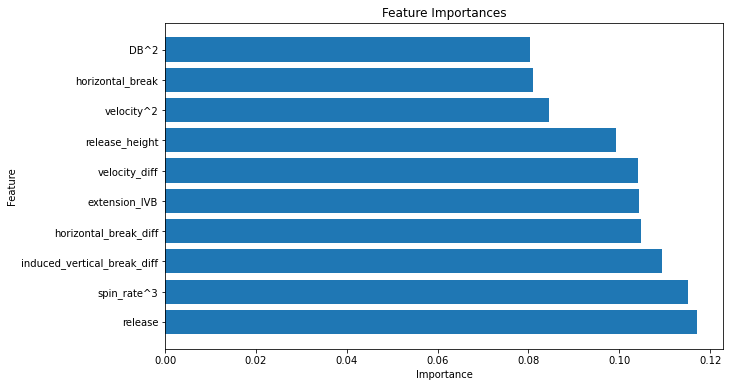

In [140]:
# Get feature importances from the model
feature_importances = model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df.index, feature_importances_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# **Training Model on RHP BB Whiff DataFrame**

In [ ]:
X = df_rhp_bb_swing[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_dist_from_C', 'release_height', 'spin_rate', 'effective_velocity', 'extension', 'differential_break', 'velocity_diff', 'horizontal_break_diff', 'induced_vertical_break_diff']]
y = df_rhp_bb_swing['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict xWhiff for the test set using the Random Forest model
y_rf_pred = model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

# Get feature importances from the model
feature_importances = model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df.index, feature_importances_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# **Training Model on RHP CH Whiff DataFrame**

In [ ]:
X = df_rhp_ch_swing[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_dist_from_C', 'release_height', 'spin_rate', 'effective_velocity', 'extension', 'differential_break', 'velocity_diff', 'horizontal_break_diff', 'induced_vertical_break_diff']]
y = df_rhp_ch_swing['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict xWhiff for the test set using the Random Forest model
y_rf_pred = model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

# Get feature importances from the model
feature_importances = model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df.index, feature_importances_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# **Training Model on LHP FB Whiff DataFrame**

In [ ]:
X = df_lhp_fb_swing[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_dist_from_C', 'release_height', 'spin_rate', 'effective_velocity', 'extension', 'differential_break', 'velocity_diff', 'horizontal_break_diff', 'induced_vertical_break_diff']]
y = df_lhp_fb_swing['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict xWhiff for the test set using the Random Forest model
y_rf_pred = model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

# Get feature importances from the model
feature_importances = model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df.index, feature_importances_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# **Training Model on LHP BB Whiff DataFrame**

In [ ]:
X = df_lhp_bb_swing[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_dist_from_C', 'release_height', 'spin_rate', 'effective_velocity', 'extension', 'differential_break', 'velocity_diff', 'horizontal_break_diff', 'induced_vertical_break_diff']]
y = df_lhp_bb_swing['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict xWhiff for the test set using the Random Forest model
y_rf_pred = model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

# Get feature importances from the model
feature_importances = model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df.index, feature_importances_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# **Training Model on LHP CH  Whiff DataFrame**

In [ ]:
X = df_lhp_ch_swing[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_dist_from_C', 'release_height', 'spin_rate', 'effective_velocity', 'extension', 'differential_break', 'velocity_diff', 'horizontal_break_diff', 'induced_vertical_break_diff']]
y = df_lhp_ch_swing['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict xWhiff for the test set using the Random Forest model
y_rf_pred = model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

# Get feature importances from the model
feature_importances = model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df.index, feature_importances_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# **Applying the Random Forest Model to the dataframes separated by hand (df_rhp and df_lhp)**

Put it in a column in the dataframe called 'stuff_plus_forest' (separate column for 'stuff_plus_xg')

In [22]:
df_rhp_fb['velocity^2'] = df_rhp_fb['velocity']**2
df_rhp_fb['extension_IVB'] = df_rhp_fb['extension'] * df_rhp_fb['induced_vertical_break']
df_rhp_fb['spin_rate^3'] = df_rhp_fb['spin_rate']**3

In [23]:
#X = df_swing_fb[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_height', 'spin_rate', 'extension', 'differential_break']]
X = df_rhp_fb[['spin_rate^3', 'velocity^2', 'induced_vertical_break', 'horizontal_break', 'release_side', 'release_height', 'spin_rate', 'differential_break', 'extension_IVB']]
y = df_rhp_fb['whiff']

In [27]:
# Predict Stuff+ scores for the test set using the Random Forest model
y_rf_pred = model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

Random Forest Mean Squared Error: 0.0905981405844522
Random Forest R-squared score: -0.037036122615350164


In [28]:
# Get feature importances from the model
feature_importances = model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                        importance
release_side              0.142433
extension_IVB             0.136538
release_height            0.130277
velocity^2                0.115775
horizontal_break          0.104506
differential_break        0.100255
spin_rate^3               0.090185
induced_vertical_break    0.090033
spin_rate                 0.089998


# **XG Boost Model Training**

In [29]:
# XG Boost Model
df_rhp_fb['velocity^2'] = df_rhp_fb['velocity']**2
df_rhp_fb['extension_spin'] = df_rhp_fb['extension'] * df_rhp_fb['spin_rate']
df_rhp_fb['spin_rate^3'] = df_rhp_fb['spin_rate']**3
df_rhp_fb['IVB^3'] = df_rhp_fb['induced_vertical_break']**3
df_rhp_fb['HB^3'] = df_rhp_fb['horizontal_break']**3
df_rhp_fb['DB^2'] = df_rhp_fb['differential_break']**2
df_rhp_fb['velocity_feature'] = df_rhp_fb['velocity^2'] *  (df_rhp_fb['velocity']**3)

In [30]:
# Select the features and target variable
X = df_rhp_fb[['HB^3', 'velocity_feature', 'IVB^3', 'release_side', 'release_height', 'extension_spin', 'DB^2']]
y = df_rhp_fb['whiff']

In [31]:
#X = df_swing_fb_sample[['velocity', 'horizontal_break', 'induced_vertical_break', 'release_side', 'release_dist_from_C', 'release_height', 'spin_axis', 'effective_velocity', 'spin_rate', 'extension', 'pitch_height', 'pitch_side', 'differential_break', 'velocity_diff', 'horizontal_break_diff', 'induced_vertical_break_diff']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost regressor object with the best parameters from the hyperparameter tuning
xgb_model = xgb.XGBRegressor(n_estimators=254, learning_rate=0.02521371583925624, max_depth=6, reg_alpha=1.0387116997045198, reg_lambda=0.47113390095546825, random_state=1)

# Train the XGBoost model using the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model's performance
xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_r2 = r2_score(y_test, y_xgb_pred)

print("XGBoost Mean Squared Error:", xgb_mse)
print("XGBoost R-squared score:", xgb_r2)

# Get feature importances from the model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

XGBoost Mean Squared Error: 0.08656915979123168
XGBoost R-squared score: 0.012782054811101506
                  importance
HB^3                0.205363
IVB^3               0.181799
velocity_feature    0.153112
release_height      0.122429
extension_spin      0.119977
DB^2                0.109020
release_side        0.108300


Feature ranking:
HB^3: 0.23256342113018036
IVB^3: 0.17717818915843964
velocity_feature: 0.1510094404220581
release_height: 0.11923085898160934
extension_spin: 0.1096758171916008
release_side: 0.10690349340438843
DB^2: 0.10343869775533676


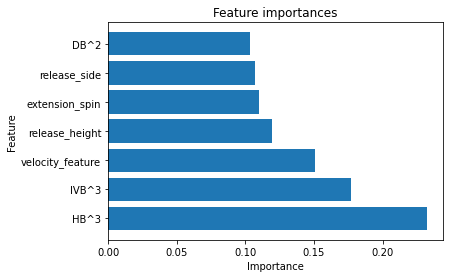

In [32]:
# Assuming X is your feature matrix and y is the target variable
model = xgb.XGBRegressor(n_estimators=254, learning_rate=0.02521371583925624, max_depth=6, reg_alpha=1.0387116997045198, reg_lambda=0.47113390095546825, random_state=1)

model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for i in range(X.shape[1]):
    print(f"{X.columns[sorted_indices[i]]}: {importances[sorted_indices[i]]}")

# Create a bar chart of feature importances
plt.barh(X.columns[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importances')
plt.show()

# **XG Boost Model Application**

In [33]:
# Predict xWhiff for all rows in the DataFrame
df_rhp_fb['xWhiff'] = xgb_model.predict(scaler.transform(df_rhp_fb[X.columns]))

# Scale the predictions so that the average is 100
df_rhp_fb['stuff_plus'] = (100 * df_rhp_fb['xWhiff'] / df_rhp_fb['xWhiff'].mean()).round(2)

df_rhp_fb['stuff_plus'].describe()

count    221574.000000
mean        100.001014
std          36.997114
min          -0.710000
25%          72.560000
50%          96.730000
75%         117.900000
max         714.890000
Name: stuff_plus, dtype: float64

# **Results**

In [34]:
df_rhp_fb['p_hand'].unique()

array(['R'], dtype=object)

In [35]:
# Sort the DataFrame by 'Stuff+' values in descending order
df_sorted = df_rhp_fb.sort_values(by='stuff_plus', ascending=False)

# Reset the index of the sorted DataFrame
df_sorted.reset_index(drop=True, inplace=True)

df_sorted.head(20)

,date,pitcher_name,p_hand,batter_side,pitch_type,velocity,horizontal_break,induced_vertical_break,release_side,release_dist_from_C,...,velocity^2,extension_IVB,spin_rate^3,extension_spin,IVB^3,HB^3,DB^2,velocity_feature,xWhiff,stuff_plus
0,2023-07-07,Félix Bautista,R,L,FB,101.6,0.25,1.75,0.28,53.95,...,10322.56,11.375,13430356633,15450.5,5.359375,0.015625,2.25,10826012887.285759,0.692126,714.89
1,2023-03-30,Ryan Helsley,R,R,FB,100.5,0.27,1.85,-0.04,53.7,...,10100.25,12.58,21184951663,18815.6,6.331625,0.019683,2.4964,10252512531.28125,0.645588,666.83
2,2023-07-19,Félix Bautista,R,L,FB,101.2,0.32,1.59,0.08,54.04,...,10241.44,10.335,13962701312,15652.0,4.019679,0.032768,1.6129,10614573839.288322,0.599712,619.44
3,2023-05-22,Ryan Helsley,R,R,FB,102.4,0.3,1.63,-0.04,53.67,...,10485.76,11.084,21601086625,18938.0,4.330747,0.027,1.7689,11258999068.426245,0.568781,587.49
4,2023-04-08,Kaleb Ort,R,L,FB,97.5,0.92,1.55,-2.77,54.18,...,9506.25,9.765,9814089221,13488.3,3.723875,0.778688,0.3969,8810956933.59375,0.510313,527.10
5,2023-07-05,Seth Lugo,R,L,FB,96.4,0.64,1.88,-1.05,54.39,...,9292.96,11.468,12358435328,14103.2,6.644672,0.262144,1.5376,8325017776.138243,0.488121,504.18
6,2023-07-05,Seth Lugo,R,R,FB,96.4,0.61,1.87,-0.78,54.4,...,9292.96,11.407,12438789013,14133.7,6.539203,0.226981,1.5876,8325017776.138243,0.487952,504.00
7,2023-07-05,Félix Bautista,R,R,FB,101.2,0.55,1.72,0.07,53.99,...,10241.44,11.18,14032398528,15678.0,5.088448,0.166375,1.3689,10614573839.288322,0.484250,500.18
8,2023-07-07,Félix Bautista,R,R,FB,101.1,0.34,1.61,0.29,53.8,...,10221.21,10.787,14402116737,16301.1,4.173281,0.039304,1.6129,10562233833.660507,0.482272,498.14
9,2023-07-22,Shintaro Fujinami,R,R,FB,101.4,1.01,1.48,-1.81,53.37,...,10281.96,10.508,7750636739,14050.9,3.241792,1.030301,0.2209,10719876326.178244,0.479812,495.60


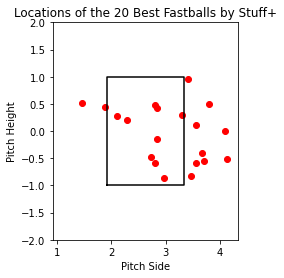

In [36]:
# Define the strike zone boundaries
sz_top = 1  
sz_bottom = -1

# The width of the strike zone is 17 inches, which is approximately 1.42 feet
# Since pitch_side is centered around 2.627, the left and right boundaries are 2.627 - 0.71 and 2.627 + 0.71
sz_left = 2.627 - 0.71
sz_right = 2.627 + 0.71

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the strike zone
ax.plot([sz_left, sz_right, sz_right, sz_left, sz_left], [sz_bottom, sz_bottom, sz_top, sz_top, sz_bottom], color='black')

# Plot the locations of the pitches
ax.scatter(df_sorted.head(20)['pitch_side'], df_sorted.head(20)['pitch_height'], color='red')

# Set the x and y axis limits to slightly larger than the strike zone
ax.set_xlim(sz_left - 1, sz_right + 1)
ax.set_ylim(sz_bottom - 1, sz_top + 1)

# Set the aspect of the plot to be equal, so the strike zone is square
ax.set_aspect('equal')

# Add labels and a title
ax.set_xlabel('Pitch Side')
ax.set_ylabel('Pitch Height')
ax.set_title('Locations of the 20 Best Fastballs by Stuff+')

# Show the plot
plt.show()

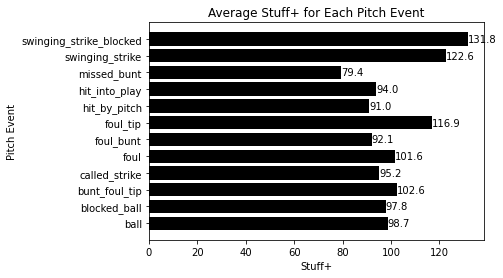

<Figure size 432x288 with 0 Axes>

In [37]:
# Average Stuff+ for each possible pitch event
# Assuming df_sorted.groupby(by='description')['stuff_plus'].mean().round(2) is stored in the variable 'series'
series = df_sorted.groupby(by='description')['stuff_plus'].mean().round(2)

# Create a bar plot of the average Stuff+ for each pitch event
plt.barh(series.index, series.values, color='black')

# Add value labels and a title
for i, value in enumerate(series.values):
    plt.text(round(value, 1), i, str(round(value, 1)), va='center')
plt.xlabel('Stuff+')
plt.ylabel('Pitch Event')
plt.title('Average Stuff+ for Each Pitch Event')

# Show the plot
plt.show()

# Save the figure as an image
plt.savefig('avg_stuff+_per_event.png', bbox_inches='tight', facecolor='white')

In [38]:
top_20 = df_sorted.head(20)
top_20[['induced_vertical_break', 'horizontal_break', 'differential_break']] = top_20[['induced_vertical_break', 'horizontal_break', 'differential_break']] * 12
top_20[['stuff_plus', 'pitcher_name', 'batter_name', 'date', 'description', 'velocity', 'spin_rate', 'induced_vertical_break', 'horizontal_break', 'differential_break']].head(30)


c:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,stuff_plus,pitcher_name,batter_name,date,description,velocity,spin_rate,induced_vertical_break,horizontal_break,differential_break
0,714.89,Félix Bautista,Max Kepler,2023-07-07,swinging_strike,101.6,2377,21.0,3.0,18.0
1,666.83,Ryan Helsley,Bo Bichette,2023-03-30,swinging_strike,100.5,2767,22.2,3.24,18.96
2,619.44,Félix Bautista,James Outman,2023-07-19,swinging_strike,101.2,2408,19.08,3.84,15.24
3,587.49,Ryan Helsley,Spencer Steer,2023-05-22,swinging_strike,102.4,2785,19.56,3.6,15.96
4,527.10,Kaleb Ort,Kerry Carpenter,2023-04-08,swinging_strike,97.5,2141,18.6,11.04,7.56
5,504.18,Seth Lugo,Mike Moustakas,2023-07-05,swinging_strike,96.4,2312,22.56,7.68,14.88
6,504.00,Seth Lugo,Jo Adell,2023-07-05,swinging_strike,96.4,2317,22.44,7.32,15.12
7,500.18,Félix Bautista,Isiah Kiner-Falefa,2023-07-05,swinging_strike,101.2,2412,20.64,6.6,14.04
8,498.14,Félix Bautista,Christian Vázquez,2023-07-07,swinging_strike,101.1,2433,19.32,4.08,15.24
9,495.60,Shintaro Fujinami,Randy Arozarena,2023-07-22,swinging_strike,101.4,1979,17.76,12.12,5.64


# Top 5 RHP Fastballs by Stuff+ (Find videos on Statcast):
Emmanuel Clase vs. Randy Arozarena, 8/12, 102.8 mph  
Ryan Helsley vs. Bo Bichette, 3/30, 100.5 MPH  
Camilo Doval vs. Brandon Nimmo, 6/30, 102.4 MPH  
Emmanuel Clase vs. Wander Franco, 8/12, 102.4 MPH  
Ryne Nelson vs. Xander Bogaerts, 4/3, 93.9 MPH  

Best by a starter:  
Jacob Degrom vs. Ryan Noda, 4/23, 101 MPH  
Justin Verlander vs. Everson Pereira, 9/1, 94.2 MPH  
Maybe more?

In [39]:
average_fb_Stuff = df_sorted.groupby('pitcher_name')['stuff_plus'].mean()
average_fb_Stuff = average_fb_Stuff.round(2)

# Sort the Series in descending order based on the average Stuff+ values
average_fb_Stuff_sorted = average_fb_Stuff.sort_values(ascending=False)

average_fb_Stuff_sorted = average_fb_Stuff_sorted.DataFrame()
average_fb_Stuff_sorted.head()

AttributeError: 'Series' object has no attribute 'DataFrame'

# **Importing Season Stats for Analysis**

In [ ]:
# Get pitching stats for 2023 from csv file
pitching_2023 = pd.read_csv('pitching_stats_2023.csv')

pitching_2023.head()

,name,player_id,year,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,era,xera,era_minus_xera_diff
0,"Mikolas, Miles",571945,2023,860,674,0.282,0.291,-0.009,0.454,0.498,-0.044,0.330,0.354,-0.024,4.78,5.44,-0.657
1,"Webb, Logan",657277,2023,850,619,0.248,0.255,-0.007,0.374,0.395,-0.021,0.283,0.295,-0.012,3.25,3.63,-0.380
2,"Gallen, Zac",668678,2023,846,574,0.238,0.254,-0.016,0.382,0.427,-0.045,0.289,0.314,-0.025,3.47,4.16,-0.689
3,"Bassitt, Chris",605135,2023,826,569,0.235,0.241,-0.006,0.403,0.405,-0.002,0.304,0.310,-0.006,3.60,4.04,-0.440
4,"Keller, Mitch",656605,2023,825,548,0.249,0.251,-0.002,0.404,0.404,0.000,0.310,0.315,-0.005,4.21,4.18,0.034


In [ ]:
# Remove the comma from the last name
pitching_2023['name'] = pitching_2023['name'].replace(',', '', regex=True)

# Edit the pitcher names so the first name is first and the last name is last
pitching_2023['name'] = pitching_2023['name'].str.split(' ', expand=True)[1] + ' ' + pitching_2023['name'].str.split(' ', expand=True)[0]

pitching_2023['name']

0       Miles Mikolas
1          Logan Webb
2          Zac Gallen
3       Chris Bassitt
4        Mitch Keller
            ...      
367      Tom Cosgrove
368    Ron Marinaccio
369        Trevor May
370    John Schreiber
371        José Ureña
Name: name, Length: 372, dtype: object

In [ ]:
new_df = average_fb_Stuff_sorted.merge(pitching_2023, left_on='pitcher_name', right_on='name')

new_df.head()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# Scatterplot of Batting Average Against (on all pitches) vs. Fastball Stuff+
plt.scatter(x=df_sorted['stuff_plus'], y=pitching_2023['ba'])

plt.xlabel('Stuff+')
plt.ylabel('Batting Average Against (on all pitches)')
plt.title('Stuff+ vs Batting Average Against')

plt.show()

# Save the figure as an image
#plt.savefig('stuff_vs_spinrate.png', bbox_inches='tight', facecolor='white')

NameError: name 'plt' is not defined

In [ ]:
# Scatterplot of Batting Average Against (just fastballs) vs. Fastball Stuff+

# **Visualizations**

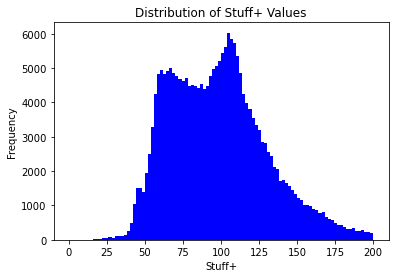

<Figure size 432x288 with 0 Axes>

In [ ]:
# Distribution of Stuff+

df_sorted['stuff_plus'].plot(kind='hist', bins=100, color='blue', range=(0, 200))

plt.xlabel('Stuff+')
plt.ylabel('Frequency')
plt.title('Distribution of Stuff+ Values')

plt.show()

# Save the figure as an image
plt.savefig('stuff_plus_distribution.png', bbox_inches='tight', facecolor='white')

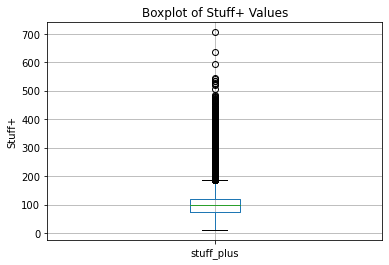

<Figure size 432x288 with 0 Axes>

In [ ]:
df_sorted.boxplot(column='stuff_plus')

plt.ylabel('Stuff+')
plt.title('Boxplot of Stuff+ Values')

plt.show()

# Save the figure as an image
plt.savefig('boxplot.png', bbox_inches='tight', facecolor='white')

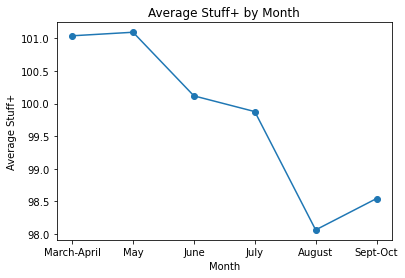

<Figure size 432x288 with 0 Axes>

In [ ]:
# Does the average Stuff+ decrease as the season progresses
march_april = df_sorted[(df_sorted['date'] >= '2023-03-30') & (df_sorted['date'] <= '2023-04-30')]
may = df_sorted[(df_sorted['date'] >= '2023-05-01') & (df_sorted['date'] <= '2023-05-31')]
june = df_sorted[(df_sorted['date'] >= '2023-06-01') & (df_sorted['date'] <= '2023-06-30')]
july = df_sorted[(df_sorted['date'] >= '2023-07-01') & (df_sorted['date'] <= '2023-07-31')]
august = df_sorted[(df_sorted['date'] >= '2023-08-01') & (df_sorted['date'] <= '2023-08-31')]
september_october = df_sorted[(df_sorted['date'] >= '2023-09-01') & (df_sorted['date'] <= '2023-09-30')]

# Plot the mean Stuff+ values for each month
plt.plot(['March-April', 'May', 'June', 'July', 'August', 'Sept-Oct'], [march_april['stuff_plus'].mean(), may['stuff_plus'].mean(), june['stuff_plus'].mean(), july['stuff_plus'].mean(), august['stuff_plus'].mean(), september_october['stuff_plus'].mean()], marker='o')
plt.xlabel('Month')
plt.ylabel('Average Stuff+')
plt.title('Average Stuff+ by Month')
plt.show()

# Save the figure as an image
plt.savefig('avg_stuff+_per_month.png', bbox_inches='tight', facecolor='white')

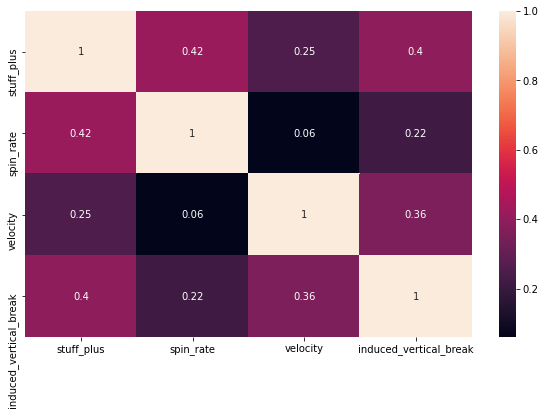

In [ ]:
plt.figure(figsize=(10, 6))

corr = df_sorted[['stuff_plus', 'spin_rate', 'velocity', 'induced_vertical_break']].corr()
sns.heatmap(corr, annot=True)

# Save the figure as an image
plt.savefig('correlation_heatmap.png', bbox_inches='tight', facecolor='white')

Variable Relationships with Stuff+

<Figure size 1080x432 with 0 Axes>

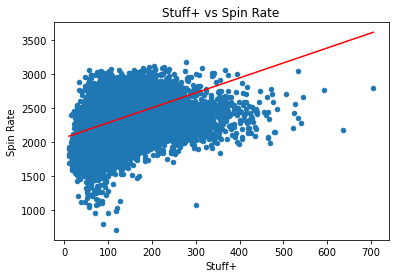

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(15, 6))

# Convert the 'stuff_plus' and 'spin_rate' columns to floats
df_sorted['stuff_plus'] = df_sorted['stuff_plus'].astype(float)
df_sorted['spin_rate'] = df_sorted['spin_rate'].astype(float)

# Drop any rows with NaN values in these columns
df_sorted = df_sorted.dropna(subset=['stuff_plus', 'spin_rate'])

# Now you can plot your data and fit a polynomial
df_sorted.plot(kind='scatter', x='stuff_plus', y='spin_rate')

# Add trendline
z = np.polyfit(df_sorted['stuff_plus'], df_sorted['spin_rate'], 1)
p = np.poly1d(z)
plt.plot(df_sorted['stuff_plus'], p(df_sorted['stuff_plus']), color='red')

plt.xlabel('Stuff+')
plt.ylabel('Spin Rate')
plt.title('Stuff+ vs Spin Rate')

plt.show()

# Save the figure as an image
plt.savefig('stuff_vs_spinrate.png', bbox_inches='tight', facecolor='white')

<Figure size 1080x432 with 0 Axes>

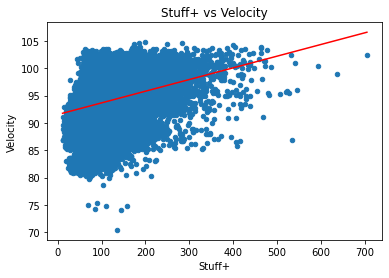

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(15, 6))

# Convert the 'stuff_plus' and 'spin_rate' columns to floats
df_sorted['stuff_plus'] = df_sorted['stuff_plus'].astype(float)
df_sorted['velocity'] = df_sorted['velocity'].astype(float)

# Drop any rows with NaN values in these columns
df_sorted = df_sorted.dropna(subset=['stuff_plus', 'velocity'])

# Now you can plot your data and fit a polynomial
df_sorted.plot(kind='scatter', x='stuff_plus', y='velocity')

# Add trendline
z = np.polyfit(df_sorted['stuff_plus'], df_sorted['velocity'], 1)
p = np.poly1d(z)
plt.plot(df_sorted['stuff_plus'], p(df_sorted['stuff_plus']), color='red')

plt.xlabel('Stuff+')
plt.ylabel('Velocity')
plt.title('Stuff+ vs Velocity')

plt.show()

# Save the figure as an image
plt.savefig('stuff_vs_velocity.png', bbox_inches='tight', facecolor='white')

<Figure size 1080x432 with 0 Axes>

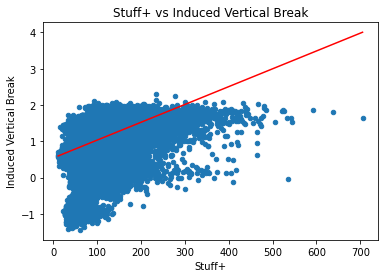

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(15, 6))

# Convert the 'stuff_plus' and 'spin_rate' columns to floats
df_sorted['stuff_plus'] = df_sorted['stuff_plus'].astype(float)
df_sorted['induced_vertical_break'] = df_sorted['induced_vertical_break'].astype(float)

# Drop any rows with NaN values in these columns
df_sorted = df_sorted.dropna(subset=['stuff_plus', 'induced_vertical_break'])

# Now you can plot your data and fit a polynomial
df_sorted.plot(kind='scatter', x='stuff_plus', y='induced_vertical_break')

# Add trendline
z = np.polyfit(df_sorted['stuff_plus'], df_sorted['induced_vertical_break'], 1)
p = np.poly1d(z)
plt.plot(df_sorted['stuff_plus'], p(df_sorted['stuff_plus']), color='red')

plt.xlabel('Stuff+')
plt.ylabel('Induced Vertical Break')
plt.title('Stuff+ vs Induced Vertical Break')

plt.show()

# Save the figure as an image
plt.savefig('stuff_vs_IVB.png', bbox_inches='tight', facecolor='white')

<Figure size 1080x432 with 0 Axes>

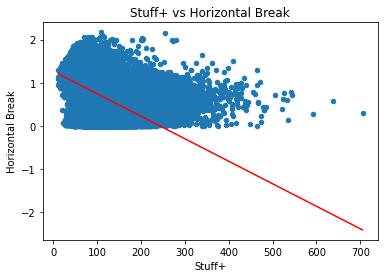

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(15, 6))

# Convert the 'stuff_plus' and 'spin_rate' columns to floats
df_sorted['stuff_plus'] = df_sorted['stuff_plus'].astype(float)
df_sorted['horizontal_break'] = df_sorted['horizontal_break'].astype(float)

# Drop any rows with NaN values in these columns
df_sorted = df_sorted.dropna(subset=['stuff_plus', 'horizontal_break'])

# Now you can plot your data and fit a polynomial
df_sorted.plot(kind='scatter', x='stuff_plus', y='horizontal_break')

# Add trendline
z = np.polyfit(df_sorted['stuff_plus'], df_sorted['horizontal_break'], 1)
p = np.poly1d(z)
plt.plot(df_sorted['stuff_plus'], p(df_sorted['stuff_plus']), color='red')

plt.xlabel('Stuff+')
plt.ylabel('Horizontal Break')
plt.title('Stuff+ vs Horizontal Break')

plt.show()

# Save the figure as an image
plt.savefig('stuff_vs_HB.png', bbox_inches='tight', facecolor='white')

# Which hitters faced the best fastball Stuff+ from RHP?

In [ ]:
# Count the number of pitches each batter has seen
pitch_count = df_sorted.groupby('batter_name')['stuff_plus'].count()

# Add the pitch count to the DataFrame
average_fb_Stuff = df_sorted.groupby('batter_name')['stuff_plus'].mean().reset_index()
average_fb_Stuff['pitch_count'] = pitch_count.values
average_fb_Stuff = average_fb_Stuff.round(2)

# Filter the DataFrame
average_fb_Stuff_filtered = average_fb_Stuff[average_fb_Stuff['pitch_count'] >= 50]

# Sort the DataFrame in descending order based on the average Stuff+ values
average_fb_Stuff_sorted = average_fb_Stuff_filtered.sort_values(by='stuff_plus', ascending=False)

top_10 = average_fb_Stuff_sorted.iloc[:10]
bottom_10 = average_fb_Stuff_sorted.iloc[-10:]

In [ ]:
# It would be interesting to find their batting average against fastballs vs. their stuff+ faced. 
# Likely negative correlation btwn BA and Stuff+ (stuff on x-axis)
print(top_10)
print("-----------------------------------------")
print(bottom_10)

          batter_name  stuff_plus  pitch_count
140   Heston Kjerstad      116.54           58
356    Tyler Heineman      116.09           98
264     Mickey Moniak      113.84          438
116       Evan Carter      113.81          275
182     Jordan Lawlar      113.05           55
192         Josh Lowe      112.82          980
80       Corey Seager      112.73          678
293   Osleivis Basabe      112.52          123
21   Andrew Stevenson      112.27           53
48     Brett Phillips      111.39          161
-----------------------------------------
          batter_name  stuff_plus  pitch_count
282     Nick Gonzales       90.21          160
104  Elehuris Montero       90.18          322
87     Dansby Swanson       89.87          972
213      Kevin Pillar       89.73          178
229      Logan Porter       89.65           55
139       Henry Davis       89.35          354
266    Miguel Andujar       89.05          100
248        Masyn Winn       88.54          230
199       José Fer

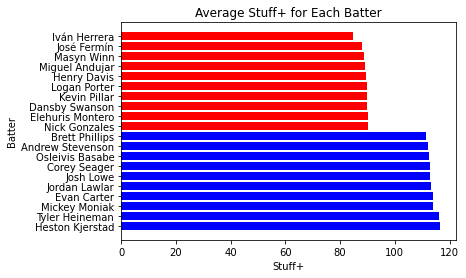

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create a bar plot of the average Stuff+ for each batter
plt.barh(top_10['batter_name'], top_10['stuff_plus'], color='blue')
plt.barh(bottom_10['batter_name'], bottom_10['stuff_plus'], color='red')

plt.xlabel('Stuff+')
plt.ylabel('Batter')
plt.title('Average Stuff+ for Each Batter')

plt.show()

# Save the figure as an image
plt.savefig('avg_stuff+_per_batter.png', bbox_inches='tight', facecolor='white')

# **Hyperparameter Tuning**

In [ ]:
"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 7),
    'reg_alpha': uniform(0.1, 1.0),
    'reg_lambda': uniform(0.1, 1.0)
}

# Create the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=1)

# Create the random search object
random_search = RandomizedSearchCV(xgb_model, param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=1)

# Fit the random search object to the data
random_search.fit(X, y)

# Print the best parameters
print(random_search.best_params_)
"""

KeyboardInterrupt: 

'learning_rate': 0.02521371583925624, 'max_depth': 6, 
'n_estimators': 254, 
'reg_alpha': 1.0387116997045198, 'reg_lambda': 0.47113390095546825

In [ ]:
"""
# List of features to include
features = ['HB^3', 'velocity^2', 'IVB^3', 'release_side', 'release_height', 'extension_spin', 'diff_break_bin_high']

# Train and evaluate the model with the diff_break_bin_high feature
X_with = df_swing_fb[features]
X_train_with, X_test_with, y_train, y_test = train_test_split(X_with, y, test_size=0.2, random_state=1)
X_train_scaled_with = scaler.fit_transform(X_train_with)
X_test_scaled_with = scaler.transform(X_test_with)
xgb_model_with = xgb.XGBRegressor(n_estimators=181, learning_rate=0.029515477895583855, random_state=1)
xgb_model_with.fit(X_train_scaled_with, y_train)
y_pred_with = xgb_model_with.predict(X_test_scaled_with)
mse_with = mean_squared_error(y_test, y_pred_with)
r2_with = r2_score(y_test, y_pred_with)

# List of features to include
features = ['HB^3', 'velocity^2', 'IVB^3', 'release_side', 'release_height', 'extension_spin']

# Train and evaluate the model without the diff_break_bin_high feature
X_without = df_swing_fb[features]
X_train_without, X_test_without, y_train, y_test = train_test_split(X_without, y, test_size=0.2, random_state=1)
X_train_scaled_without = scaler.fit_transform(X_train_without)
X_test_scaled_without = scaler.transform(X_test_without)
xgb_model_without = xgb.XGBRegressor(n_estimators=181, learning_rate=0.029515477895583855, random_state=1)
xgb_model_without.fit(X_train_scaled_without, y_train)
y_pred_without = xgb_model_without.predict(X_test_scaled_without)
mse_without = mean_squared_error(y_test, y_pred_without)
r2_without = r2_score(y_test, y_pred_without)

# Print the results
print("With diff_break_bin_high:")
print("Mean Squared Error:", mse_with)
print("R-squared score:", r2_with)
print("\nWithout diff_break_bin_high:")
print("Mean Squared Error:", mse_without)
print("R-squared score:", r2_without)
"""

'\n# List of features to include\nfeatures = [\'HB^3\', \'velocity^2\', \'IVB^3\', \'release_side\', \'release_height\', \'extension_spin\', \'diff_break_bin_high\']\n\n# Train and evaluate the model with the diff_break_bin_high feature\nX_with = df_swing_fb[features]\nX_train_with, X_test_with, y_train, y_test = train_test_split(X_with, y, test_size=0.2, random_state=1)\nX_train_scaled_with = scaler.fit_transform(X_train_with)\nX_test_scaled_with = scaler.transform(X_test_with)\nxgb_model_with = xgb.XGBRegressor(n_estimators=181, learning_rate=0.029515477895583855, random_state=1)\nxgb_model_with.fit(X_train_scaled_with, y_train)\ny_pred_with = xgb_model_with.predict(X_test_scaled_with)\nmse_with = mean_squared_error(y_test, y_pred_with)\nr2_with = r2_score(y_test, y_pred_with)\n\n# List of features to include\nfeatures = [\'HB^3\', \'velocity^2\', \'IVB^3\', \'release_side\', \'release_height\', \'extension_spin\']\n\n# Train and evaluate the model without the diff_break_bin_high fea

In [ ]:
"""
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best estimator to make predictions
y_pred = grid_search.best_estimator_.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)
"""

'\nfrom sklearn.model_selection import GridSearchCV\n\n# Define the parameter grid\nparam_grid = {\n    \'n_estimators\': [50, 100, 150, 200],\n    \'learning_rate\': [0.01, 0.1, 0.2, 0.3]\n}\n\n# Create the GridSearchCV object\ngrid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid, cv=5, scoring=\'neg_mean_squared_error\')\n\n# Fit the GridSearchCV object to the data\ngrid_search.fit(X_train_scaled, y_train)\n\n# Print the best parameters and the best score\nprint("Best parameters:", grid_search.best_params_)\nprint("Best score:", grid_search.best_score_)\n\n# Use the best estimator to make predictions\ny_pred = grid_search.best_estimator_.predict(X_test_scaled)\n\n# Evaluate the model\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\n\nprint("Mean Squared Error:", mse)\nprint("R-squared score:", r2)\n'

In [ ]:
"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.3)
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=42), param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Use the best estimator to make predictions
y_pred = random_search.best_estimator_.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)
"""

'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import randint, uniform\n\n# Define the parameter distribution\nparam_dist = {\n    \'n_estimators\': randint(50, 200),\n    \'learning_rate\': uniform(0.01, 0.3)\n}\n\n# Create the RandomizedSearchCV object\nrandom_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=42), param_dist, n_iter=50, cv=5, scoring=\'neg_mean_squared_error\', random_state=42)\n\n# Fit the RandomizedSearchCV object to the data\nrandom_search.fit(X_train_scaled, y_train)\n\n# Print the best parameters and the best score\nprint("Best parameters:", random_search.best_params_)\nprint("Best score:", random_search.best_score_)\n\n# Use the best estimator to make predictions\ny_pred = random_search.best_estimator_.predict(X_test_scaled)\n\n# Evaluate the model\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\n\nprint("Mean Squared Error:", mse)\nprint("R-squared score:", r2)\n'

Best parameters: {'learning_rate': 0.029515477895583855, 'n_estimators': 181}
Best score: -0.1588402246170339
Mean Squared Error: 0.1595497477178634
R-squared score: 0.02342727228548369

# **RHP Breakingballs Stuff+**

# **RHP Offspeed Stuff+**

# **LHP Fastball Stuff+**

# **LHP Breakingballs Stuff+**

Group Sliders and Curveballs in the same dataframe

# **LHP Offspeed Pitches Stuff+**

Group changeups, splitters, screwballs, etc. in the same dataframe